
# CGM Glucose‑Prediction Buddy — Colab Simulation & Export

This notebook lets us **rehearse the entire pipeline in Colab**

1) Load CGM data (Dexcom/Libre CSV or synthetic)  
2) Resample to **5‑minute** intervals and create **12‑step windows** (60 minutes history)  
3) Train a **small LSTM (32 units)** to predict **15‑min ahead** glucose  
4) **Quantize** the model and export **TensorFlow Lite (int8)**  
5) Verify TFLite predictions ≈ Keras predictions  
6) Run a **virtual device loop** that mimics the ESP32 logic (LED/buzzer alerts)  
7) Export `glucose.tflite` and a **C array header** `glucose.h` you can drop into Arduino

> **Normalization constants** are defined once and reused here and on-device to keep the math aligned.


## 0) Setup

In [ ]:
# ✅ Colab-friendly setup (TF 2.19+ already present on Colab)
!pip -q install pandas numpy scikit-learn matplotlib

import numpy as np, pandas as pd, matplotlib.pyplot as plt, math, io, os, time, json
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
print("TF:", tf.__version__)
# We don't need tflite_runtime on Colab; we'll use tf.lite.Interpreter below.


TF: 2.19.0




---


## 1) Load CGM data (CSV) or generate synthetic data

**Option A**: Upload a CSV with columns `timestamp` and `glucose` (mg/dL).  
**Option B**: Generate a synthetic time‑series that looks like CGM data. We will use this option here for now


In [ ]:
from google.colab import files

USE_SYNTHETIC = True  # False to upload real CSV with columns: timestamp, glucose

if not USE_SYNTHETIC:
    up = files.upload()
    fname = list(up.keys())[0]
    df = pd.read_csv(io.BytesIO(up[fname]), parse_dates=['timestamp'])
else:
    # -----------------------------
    # Improved synthetic CGM series
    # -----------------------------
    np.random.seed(42)
    start = datetime.now() - timedelta(days=7)   # more days helps variety
    minutes = 7*24*60
    ts = [start + timedelta(minutes=i) for i in range(minutes)]

    # User-tunable parameters
    BASELINE_START = 110.0
    CLAMP_LO, CLAMP_HI = 60.0, 300.0

    # Meal / exercise event counts
    MEALS_PER_DAY = 3
    EXER_PER_DAY  = 1
    STRESS_PER_DAY = 1

    # Meal response parameters (gamma-like bump)
    def meal_bump(t, A, tau_r=15.0, tau_d=70.0, alpha=2.0):
        # t in minutes; bump peaks ~ (alpha*tau_d)
        t = np.maximum(t, 0.0)
        return A * ((t/tau_r)**alpha) * np.exp(-t/tau_d)

    # Exercise drop (smooth negative bump)
    def exercise_drop(t, A, tau=45.0):
        t = np.maximum(t, 0.0)
        # rapid onset then recovery
        return -A * (t/tau) * np.exp(-t/tau)

    # Slow dawn phenomenon (morning rise over 2–3 hours)
    def dawn_rise(minute_of_day, A=15.0):
        # 4am–8am rise
        # minute_of_day: 0..1439
        if 240 <= minute_of_day <= 480:
            x = (minute_of_day - 240) / (480 - 240)  # 0..1
            return A * (0.5 - 0.5*np.cos(np.pi*x))    # smooth ramp
        return 0.0

    # Create event times
    meal_times = []
    ex_times   = []
    stress_times = []
    for d in range(7):
        day_start = d*24*60
        # Meals around: 8am, 1pm, 8pm with jitter
        for center in [8*60, 13*60, 20*60]:
            t0 = day_start + center + np.random.randint(-30, 31)
            meal_times.append(t0)
        # Exercise around 6pm with jitter
        ex_times.append(day_start + 18*60 + np.random.randint(-60, 61))
        # Stress spike around 11am with jitter
        stress_times.append(day_start + 11*60 + np.random.randint(-90, 91))

    meal_times = sorted([t for t in meal_times if 0 <= t < minutes])
    ex_times   = sorted([t for t in ex_times if 0 <= t < minutes])
    stress_times = sorted([t for t in stress_times if 0 <= t < minutes])

    # Precompute contributions
    meal_contrib = np.zeros(minutes, dtype=np.float32)
    ex_contrib   = np.zeros(minutes, dtype=np.float32)
    stress_contrib = np.zeros(minutes, dtype=np.float32)

    # Meals: allow mixed response (normal-ish + T2D-ish)
    for t0 in meal_times:
        A = np.random.uniform(30, 90)             # peak effect range
        # slower recovery sometimes
        tau_d = np.random.uniform(60, 120)
        tau_r = np.random.uniform(10, 25)
        alpha = np.random.uniform(1.5, 3.0)
        dur = int(4*60)  # 4h window
        idx = np.arange(t0, min(minutes, t0+dur))
        meal_contrib[idx] += meal_bump(idx - t0, A=A, tau_r=tau_r, tau_d=tau_d, alpha=alpha)
        meal_contrib = np.clip(meal_contrib, 0, 120)


    # Exercise: drops + recovery
    for t0 in ex_times:
        A = np.random.uniform(20, 70)
        tau = np.random.uniform(30, 70)
        dur = int(3*60)  # 3h
        idx = np.arange(t0, min(minutes, t0+dur))
        ex_contrib[idx] += exercise_drop(idx - t0, A=A, tau=tau)

    # Stress spikes: quicker, smaller rises
    for t0 in stress_times:
        A = np.random.uniform(10, 35)
        tau_d = np.random.uniform(20, 45)
        tau_r = np.random.uniform(5, 12)
        alpha = np.random.uniform(1.0, 2.5)
        dur = int(2*60)
        idx = np.arange(t0, min(minutes, t0+dur))
        stress_contrib[idx] += meal_bump(idx - t0, A=A, tau_r=tau_r, tau_d=tau_d, alpha=alpha)

    # Baseline drift (random walk) + slight mean reversion
    g = BASELINE_START
    glucose = []
    for i in range(minutes):
        minute_of_day = i % (24*60)

        # random walk + mean reversion towards 105
        g += np.random.normal(0, 0.6)
        g += -0.015*(g - 110.0)


        # dawn
        g += dawn_rise(minute_of_day, A=np.random.uniform(10, 22))

        # add event contributions
        g_eff = g + meal_contrib[i] + ex_contrib[i] + stress_contrib[i]

        # note: add sensor noise (CGM noise)
        g_eff += np.random.normal(0, 2.0)



        # clamp wide
        g_eff = float(np.clip(g_eff, CLAMP_LO, CLAMP_HI))

        # extra recovery pressure when very high
        if g_eff > 220:
          g_eff -= 0.02*(g_eff - 220)

        glucose.append(g_eff)

    # Optional: sensor lag (simple EMA low-pass)
    glucose = np.array(glucose, dtype=np.float32)
    alpha_lag = 0.12  # smaller = more lag
    lagged = np.zeros_like(glucose)
    lagged[0] = glucose[0]
    for i in range(1, minutes):
        lagged[i] = (1-alpha_lag)*lagged[i-1] + alpha_lag*glucose[i]

    df = pd.DataFrame({'timestamp': ts, 'glucose': lagged})

df.head(), df.tail(), df.shape


(                   timestamp     glucose
 0 2025-12-10 11:51:27.768466  109.195267
 1 2025-12-10 11:52:27.768466  109.357712
 2 2025-12-10 11:53:27.768466  109.450722
 3 2025-12-10 11:54:27.768466  109.795586
 4 2025-12-10 11:55:27.768466  110.192429,
                        timestamp     glucose
 10075 2025-12-17 11:46:27.768466  170.349976
 10076 2025-12-17 11:47:27.768466  163.104630
 10077 2025-12-17 11:48:27.768466  156.501282
 10078 2025-12-17 11:49:27.768466  151.016739
 10079 2025-12-17 11:50:27.768466  146.041077,
 (10080, 2))

In [ ]:
ser = df.set_index("timestamp")["glucose"].astype("float32") \
        .resample("5min").mean().interpolate("time")

d15 = ser.shift(-15//5) - ser   # 15-min delta
d15 = d15.dropna().values

print("Δ15 min stats (mg/dL):")
for p in [1,5,10,25,50,75,90,95,99]:
    print(f"p{p:02d}:", np.percentile(d15, p))
print("min/max:", d15.min(), d15.max())


Δ15 min stats (mg/dL):
p01: -90.82642
p05: -26.39009
p10: -10.008787
p25: -1.5203476
p50: 0.0
p75: 1.7513618
p90: 16.408535
p95: 38.1964
p99: 58.060577
min/max: -135.88402 91.41186


## 2) Resample to 5‑minute intervals & visualise

In [ ]:
# --- Cleaning & resample (safe) ---
MIN_G, MAX_G = 40.0, 300.0

df = df.copy()
df['glucose'] = pd.to_numeric(df['glucose'], errors='coerce')
df = df.dropna(subset=['timestamp','glucose']).sort_values('timestamp')

ser = df.set_index('timestamp')['glucose'].astype('float32')

ser_5 = (
    ser.resample('5min').mean()      # instead of '5T'
       .interpolate('time', limit=12) # fill gaps up to 1 hr
       .ffill().bfill()               # fill any ends
       .clip(lower=MIN_G, upper=MAX_G)
       .astype('float32')
)

print("NaNs after clean:", int(ser_5.isna().sum()))
print("Resampled min/max:", float(ser_5.min()), float(ser_5.max()))


NaNs after clean: 0
Resampled min/max: 87.86262512207031 298.3997802734375



## 3) Create 60‑min windows (12 steps) → predict next 15‑min point

We normalise with the same scale that we will use on‑device:

```
scaled = (value - MIN_G) / (MAX_G - MIN_G)
value  = scaled*(MAX_G - MIN_G) + MIN_G
```


In [ ]:
WIN = 12            # 60 min history
HORIZON = 3         # set to 3 for explicit 15-min ahead on 5-min data

def scale(v):   return (v - MIN_G) / (MAX_G - MIN_G)
def unscale(s): return s*(MAX_G - MIN_G) + MIN_G

vals   = ser_5.values.astype('float32')
scaled = scale(vals)

import numpy as np
assert np.isfinite(scaled).all(), "Scaled series has NaN/inf."

X, y = [], []
for i in range(len(scaled) - WIN - HORIZON):
    X.append(scaled[i:i+WIN])
    y.append(scaled[i+WIN+HORIZON-1])

X = np.array(X, dtype='float32')[..., None]
y = np.array(y, dtype='float32')[..., None]
print("X:", X.shape, "y:", y.shape)

N = len(X); split = int(N*0.8)
Xtr, Xval = X[:split], X[split:]
ytr, yval = y[:split], y[split:]

print("Any NaN in Xtr?", np.isnan(Xtr).any(), "| ytr?", np.isnan(ytr).any())


X: (2002, 12, 1) y: (2002, 1)
Any NaN in Xtr? False | ytr? False


## 4) Build & train a compact LSTM (32 units)

Epoch 1/15
26/26 - 3s - 108ms/step - loss: 0.2324 - root_mean_squared_error: 0.4821 - val_loss: 0.0408 - val_root_mean_squared_error: 0.2020
Epoch 2/15
26/26 - 0s - 12ms/step - loss: 0.0365 - root_mean_squared_error: 0.1910 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1650
Epoch 3/15
26/26 - 0s - 14ms/step - loss: 0.0276 - root_mean_squared_error: 0.1661 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1611
Epoch 4/15
26/26 - 0s - 17ms/step - loss: 0.0254 - root_mean_squared_error: 0.1593 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1547
Epoch 5/15
26/26 - 0s - 13ms/step - loss: 0.0243 - root_mean_squared_error: 0.1558 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1507
Epoch 6/15
26/26 - 0s - 12ms/step - loss: 0.0243 - root_mean_squared_error: 0.1559 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1495
Epoch 7/15
26/26 - 0s - 11ms/step - loss: 0.0225 - root_mean_squared_error: 0.1500 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1458
Epoch 8/15
26/26 - 

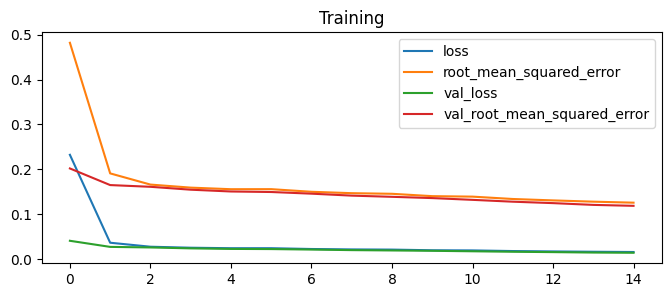

Validation RMSE: 30.86 mg/dL, MAE: 19.94 mg/dL


In [ ]:

tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(WIN,1)),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1, activation=None)
])
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
hist = model.fit(Xtr, ytr, epochs=15, batch_size=64, validation_data=(Xval, yval), verbose=2)
pd.DataFrame(hist.history).plot(figsize=(8,3)); plt.title("Training"); plt.show()

# Evaluate in mg/dL
pred_val = model.predict(Xval, verbose=0)
rmse = np.sqrt(np.mean((unscale(pred_val)-unscale(yval))**2))
mae  = np.mean(np.abs(unscale(pred_val)-unscale(yval)))
print(f"Validation RMSE: {rmse:.2f} mg/dL, MAE: {mae:.2f} mg/dL")


# 4b) Confirm real-world metrics

Goal: to see mg/dL metrics from validation set

In [ ]:
pred_val = model.predict(Xval, verbose=0)
rmse = float(np.sqrt(np.mean((unscale(pred_val)-unscale(yval))**2)))
mae  = float(np.mean(np.abs(unscale(pred_val)-unscale(yval))))
print(f"Validation RMSE: {rmse:.2f} mg/dL, MAE: {mae:.2f} mg/dL")


Validation RMSE: 30.86 mg/dL, MAE: 19.94 mg/dL


## 5a) Build an unrolled clone (no retrain)

In [ ]:
# 5a) Build an unrolled LSTM clone with fixed batch for TFLite conversion
inp = tf.keras.Input(shape=(WIN,1), batch_size=1)  # fixed batch helps make shapes static
x   = tf.keras.layers.LSTM(32, return_sequences=False, unroll=True)(inp)
out = tf.keras.layers.Dense(1)(x)
conv_model = tf.keras.Model(inp, out)

# Copy weights from the trained model
conv_model.set_weights(model.get_weights())
print("Unrolled clone ready for conversion.")


Unrolled clone ready for conversion.


## 5) Convert to TFLite (post‑training quantization)

In [ ]:
# 5) Convert to TFLite (post-training quantization) using the unrolled clone
def rep_gen():
    # 1) Explicit extremes: all-0 and all-1 windows
    X0 = np.zeros((1, WIN, 1), dtype=np.float32)          # 0.0
    X1 = np.ones((1, WIN, 1), dtype=np.float32)           # 1.0
    yield [X0]
    yield [X1]

    # 2) A few ramps across 0..1
    for k in range(10):
        ramp = np.linspace(0.0, 1.0, WIN, dtype=np.float32).reshape(1, WIN, 1)
        yield [ramp]
        yield [ramp[:, ::-1, :]]  # descending

    # 3) Real training windows (denser than every 200)
    step = max(1, len(Xtr)//200)  # about ~200 samples
    for i in range(0, len(Xtr), step):
        yield [Xtr[i:i+1].astype(np.float32)]


converter = tf.lite.TFLiteConverter.from_keras_model(conv_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = rep_gen

# Mixed quantization: INT8 input, FLOAT output
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.float32

# IMPORTANT: do NOT force full-int8 ops
# Remove / do not set:
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

tflite_model = converter.convert()

SAVE_DIR = "/content"          # Colab's default
tflite_path = f"{SAVE_DIR}/glucose.tflite"

with open("/content/glucose.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite bytes:", len(tflite_model))



Saved artifact at '/tmp/tmpoy9gg5ka'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 12, 1), dtype=tf.float32, name='keras_tensor_3')
Output Type:
  TensorSpec(shape=(1, 1), dtype=tf.float32, name=None)
Captures:
  134829734724816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134829734726928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134829734728464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134829734725392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134829734729040: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


TFLite bytes: 58552


## 6) Verify TFLite vs Keras predictions on a sample

In [ ]:

# Use TF Lite in Python to compare (use tflite_runtime if preferred)
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()
inp = interpreter.get_input_details()[0]
out = interpreter.get_output_details()[0]

# Quantization parameters
inp_scale, inp_zero = inp['quantization']
out_scale, out_zero = out['quantization']

def tflite_infer(x):
    # x: (1, WIN, 1) float32 in [0,1]
    xi = (x / inp_scale + inp_zero).astype(np.int8)
    interpreter.set_tensor(inp['index'], xi)
    interpreter.invoke()

    y = interpreter.get_tensor(out['index'])

    # If output is float32, return it directly
    if out["dtype"] == np.float32:
        return float(y.reshape(-1)[0])

    # Else (int8 output), dequantize
    yi = y.astype(np.int32)
    return float((yi.reshape(-1)[0] - out_zero) * out_scale)

i = 0
keras_pred = model.predict(Xval[i:i+1], verbose=0)
tflite_pred = tflite_infer(Xval[i:i+1])
print("Keras scaled:", float(keras_pred))
print("TFLite scaled:", float(tflite_pred))

print("Keras mg/dL:", float(unscale(keras_pred)))
print("TFLite mg/dL:", float(unscale(tflite_pred)))

print("TFLite input dtype:", inp["dtype"], "quant:", inp["quantization"])
print("TFLite output dtype:", out["dtype"], "quant:", out["quantization"])

print("inp quant:", inp["quantization"], "dtype:", inp["dtype"])
print("out dtype:", out["dtype"], "quant:", out["quantization"])


Keras scaled: 0.9037221670150757
TFLite scaled: 0.9010630249977112
Keras mg/dL: 274.9677734375
TFLite mg/dL: 274.2763864994049
TFLite input dtype: <class 'numpy.int8'> quant: (0.003921568859368563, -128)
TFLite output dtype: <class 'numpy.float32'> quant: (0.0, 0)
inp quant: (0.003921568859368563, -128) dtype: <class 'numpy.int8'>
out dtype: <class 'numpy.float32'> quant: (0.0, 0)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
/tmp/ipython-input-2192880851.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Keras scaled:", float(keras_pred))
/tmp/ipython-input-2192880851.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Keras mg/dL:", float(unscale(ke

## 7) Virtual device loop (LED/Buzzer decisions)

/tmp/ipython-input-1646451366.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nxt = float(unscale(yval[(t % len(yval))]))


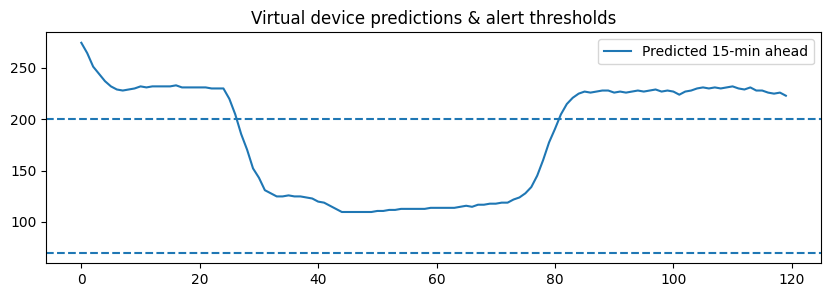

t+  5min:  274.3 mg/dL  ->  LED=RED, BUZZ
t+ 10min:  264.2 mg/dL  ->  LED=RED, BUZZ
t+ 15min:  251.1 mg/dL  ->  LED=RED, BUZZ
t+ 20min:  244.0 mg/dL  ->  LED=RED, BUZZ
t+ 25min:  236.9 mg/dL  ->  LED=RED, BUZZ
t+ 30min:  231.9 mg/dL  ->  LED=RED, BUZZ
t+ 35min:  228.8 mg/dL  ->  LED=RED, BUZZ
t+ 40min:  227.8 mg/dL  ->  LED=RED, BUZZ
t+ 45min:  228.8 mg/dL  ->  LED=RED, BUZZ
t+ 50min:  229.8 mg/dL  ->  LED=RED, BUZZ
t+ 55min:  231.9 mg/dL  ->  LED=RED, BUZZ
t+ 60min:  230.9 mg/dL  ->  LED=RED, BUZZ
t+ 65min:  231.9 mg/dL  ->  LED=RED, BUZZ
t+ 70min:  231.9 mg/dL  ->  LED=RED, BUZZ
t+ 75min:  231.9 mg/dL  ->  LED=RED, BUZZ
t+ 80min:  231.9 mg/dL  ->  LED=RED, BUZZ
t+ 85min:  232.9 mg/dL  ->  LED=RED, BUZZ
t+ 90min:  230.9 mg/dL  ->  LED=RED, BUZZ
t+ 95min:  230.9 mg/dL  ->  LED=RED, BUZZ
t+100min:  230.9 mg/dL  ->  LED=RED, BUZZ


In [ ]:

HIGH_TH = 200.0
LOW_TH  = 70.0

ring = list(Xval[0,:,0])  # initial window from validation set
predictions = []
flags = []

def infer_scaled_window(win_vals_scaled):
    x = np.array(win_vals_scaled, dtype=np.float32).reshape(1, WIN, 1)
    y_scaled = tflite_infer(x)          # scaled 0..1
    return float(unscale(y_scaled))     # mg/dL

for t in range(120):  # simulate 120 x 5-min steps = 10 hours
    pred = infer_scaled_window(ring[-WIN:])
    predictions.append(pred)
    # Decision logic (same as on device)
    if pred > HIGH_TH:
        flags.append("LED=RED, BUZZ")
    elif pred < LOW_TH:
        flags.append("LED=BLUE, BUZZ")
    else:
        flags.append("LED=OFF")
    # advance stream by appending the actual next point (teacher forcing)
    nxt = float(unscale(yval[(t % len(yval))]))
    ring.append(scale(nxt))

# Plot predicted mg/dL and mark alerts
plt.figure(figsize=(10,3))
plt.plot(predictions, label="Predicted 15-min ahead")
plt.axhline(HIGH_TH, linestyle="--")
plt.axhline(LOW_TH, linestyle="--")
plt.legend(); plt.title("Virtual device predictions & alert thresholds"); plt.show()

# Show first 20 decisions
for i in range(20):
    print(f"t+{5*(i+1):>3}min: {predictions[i]:6.1f} mg/dL  ->  {flags[i]}")


## 8) Export files for Arduino (downloadable)

In [ ]:
# 8) Export files for Arduino (downloadable)

import os, json, pathlib

SAVE_DIR = "/content"                 # Colab’s working directory
TFLITE    = f"{SAVE_DIR}/glucose.tflite"
HEADER    = f"{SAVE_DIR}/glucose.h"
NORMS     = f"{SAVE_DIR}/normalization.json"

# Create a C array header from the TFLite blob
assert os.path.exists(TFLITE), f"Missing {TFLITE} — run Step 5 first."
!xxd -i /content/glucose.tflite > /content/glucose.h

# Save normalization constants used in training
with open(NORMS, "w") as f:
    json.dump({"MIN_G": float(MIN_G), "MAX_G": float(MAX_G), "WIN": int(WIN)}, f, indent=2)

print("Wrote:")
for p in [TFLITE, HEADER, NORMS]:
    print(" •", p, "(", os.path.getsize(p), "bytes )")

# One-click downloads in Colab
from google.colab import files
files.download(TFLITE)
files.download(HEADER)
files.download(NORMS)


Wrote:
 • /content/glucose.tflite ( 58552 bytes )
 • /content/glucose.h ( 361168 bytes )
 • /content/normalization.json ( 50 bytes )


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 9) Model size & ESP32 memory budget check

In [ ]:

# Parameter count for the LSTM layer
lstm_units, input_dim = 32, 1
params_lstm = 4 * (lstm_units*(input_dim + lstm_units) + lstm_units)  # kernel + recurrent + bias per gate
params_dense = lstm_units*1 + 1
params_total = params_lstm + params_dense
print("Total params:", params_total, " (~", params_total*1, "int8 bytes )")

# Rough activations arena estimate (very conservative fudge factor for LSTM)
arena_bytes = 30*1024
print("Suggest starting tensor_arena size:", arena_bytes, "bytes")


Total params: 4385  (~ 4385 int8 bytes )
Suggest starting tensor_arena size: 30720 bytes



## 10) Next steps

* copy **`glucose.h`** into Arduino sketch folder and keep the **`MIN_G` / `MAX_G` / `WIN`** constants identical.
* Replace the synthetic/CSV stream here with a Nightscout REST poller on the laptop, or feed manual numbers via Serial to the dev board first.
* If validation RMSE looks high (>25 mg/dL), try: more epochs (30–40), a slightly wider LSTM (64 units), or a 3‑step horizon label to truly target 15‑min ahead.
